# Numerical Calculation and plotting the fixation probability of two-patch meta-population

In [28]:
import numpy as np
import itertools
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

In [29]:
local_size_patch_one=7
local_size_patch_two=3
Fitness=np.linspace(0.1,2.,20)
Fitness1=np.linspace(0.1,2,100)
migration_probability=[0.000001,0.01,0.1,0.5,1]

In [30]:
number_states=(local_size_patch_two+1)*(local_size_patch_one+1) #number of states
patch_one=np.arange(local_size_patch_one+1).tolist()
patch_two=np.arange(local_size_patch_two+1).tolist()
patch_combination=list(itertools.product(patch_one,patch_two))

**The transition matrix**

In [31]:
def transition_matrix(l,r):
    """
    this function compute the transition matrix of 
    an evolutionary two-patch metapopulation
    Parameters
    ----------
    l:  migration probability
    
    r: fitness
    """
    
    T=np.zeros([number_states,number_states])
    for i in range(local_size_patch_one+1):
        for j in range(local_size_patch_two+1):
            total_fitness=r*(i+j)+local_size_patch_one+local_size_patch_two-(i+j)
            
            first_index=patch_combination.index((i,j))
            
            if i+1<=local_size_patch_one:
                t_iplus=(r*(1-l)*i+r*l*j)*(local_size_patch_one-i)/(local_size_patch_one*total_fitness)
                second_index=patch_combination.index((i+1,j))
                T[first_index,second_index]=t_iplus
                
            if i-1>=0:
                t_iminus=((1-l)*(local_size_patch_one-i)+l*(local_size_patch_two-j))*i/(local_size_patch_one*total_fitness)
                second_index=patch_combination.index((i-1,j))
                T[first_index,second_index]=t_iminus
                
            if j+1<=local_size_patch_two:    
                t_jplus=(r*(1-l)*j+r*l*i)*(local_size_patch_two-j)/(local_size_patch_two*total_fitness)
                second_index=patch_combination.index((i,j+1))
                T[first_index,second_index]=t_jplus
                
            if j-1>=0:
                t_jminus=((1-l)*(local_size_patch_two-j)+l*(local_size_patch_one-i))*j/(local_size_patch_two*total_fitness)
                second_index=patch_combination.index((i,j-1))
                T[first_index,second_index]=t_jminus
        
            
    for i in range(number_states):
        T[i,i]=1-T[i].sum()   
    return T 

$\phi= (Q-I)^{-1}R$ where $\phi$ is the absorption probability from any state to one of the absorbing points. 
$Q$ is the transition matrix between transient states. $I$ is the identity matrix and $R$ represent the probability of transition from any transient states to absorbing states.

In [32]:
for l in migration_probability:
    f=open('two-patch-numerical-N1_'+str(local_size_patch_one)+'-N2_'+str(local_size_patch_two)+'_mig_'+str(l)+'.txt','w')
    for r in Fitness:
        TM=transition_matrix(l,r)
 
        transient_matrix=TM[1:number_states-1,1:number_states-1]
        a=TM[1:number_states-1,0]
        b=TM[1:number_states-1,number_states-1]
        R=np.concatenate((a, b),axis=0)
        R=np.transpose(R.reshape((2,number_states-2)))
   
        Identity=np.identity(number_states-2)
        c=Identity-transient_matrix
        inverse=np.linalg.inv(c)
    
        Probability=np.dot(inverse,R)
    
        fix_prob=(local_size_patch_two*Probability[0,1]+local_size_patch_one*Probability[local_size_patch_two,1])/(local_size_patch_one+local_size_patch_two)
        f.write(str(r)+'\t'+str(fix_prob)+'\n')
    
    f.close()    
    

**fixation probability of a well-mixed population**

In [33]:
def fix_prob_well_mixed(fitness, pop_size):
    """
    fixation probability of a well-mixed population 
    with size pop_size 
    """
    return (1-1/fitness)/(1-(1/fitness)**pop_size)

**Fixation probability of a two-patch meta-population in low migration regime**

In [34]:
def fix_prob_two_patch(fitness,local_size_patch_one,local_size_patch_two):
    """
    fixation probability of a two-patch meta-population

    """
    return fix_prob_well_mixed(fitness, local_size_patch_one)*fix_prob_well_mixed(fitness, local_size_patch_two)*(local_size_patch_one/(local_size_patch_one+local_size_patch_two) /(fix_prob_well_mixed(fitness, local_size_patch_two)+local_size_patch_two*fix_prob_well_mixed(1/fitness, local_size_patch_one)/(local_size_patch_one*fitness))+local_size_patch_two/(local_size_patch_one+local_size_patch_two)/(fix_prob_well_mixed(fitness, local_size_patch_one)+local_size_patch_one*fix_prob_well_mixed(1/fitness, local_size_patch_two)/(local_size_patch_two*fitness)))

**Fixation probability of a two-patch meta-population when migration probability is 1:**

In [35]:
def h2(fitness,pop_size_1,pop_size_2):
    return (pop_size_1/pop_size_2+1/fitness)/(pop_size_1/pop_size_2+fitness)

def h1(fitness,pop_size_1,pop_size_2):
    return (pop_size_2/pop_size_1+1/fitness)/(pop_size_2/pop_size_1+fitness)

def phi1(fitness,pop_size_1,pop_size_2):
    return (h1(fitness, pop_size_1, pop_size_2)-1)/((h1(fitness, pop_size_1, pop_size_2))**pop_size_1*(h2(fitness, pop_size_1, pop_size_2))**pop_size_2-1)


def phi2(fitness,pop_size_1,pop_size_2):
    return (h2(fitness, pop_size_1, pop_size_2)-1)/((h1(fitness, pop_size_1, pop_size_2))**pop_size_1*(h2(fitness, pop_size_1, pop_size_2))**pop_size_2-1)

def phi (fitness,pop_size_1, pop_size_2):
    return (pop_size_1* phi1(fitness,pop_size_1,pop_size_2)+pop_size_2* phi2(fitness,pop_size_1,pop_size_2))/(pop_size_1+pop_size_2)

**Import numerical data for different migration probabilities**

In [36]:
numerical_fix_prob_10e_6=np.loadtxt('two-patch-numerical-N1_7-N2_3_mig_1e-06.txt')
numerical_fix_prob_10e_2=np.loadtxt('two-patch-numerical-N1_7-N2_3_mig_0.01.txt')
numerical_fix_prob_01=np.loadtxt('two-patch-numerical-N1_7-N2_3_mig_0.1.txt')
numerical_fix_prob_05=np.loadtxt('two-patch-numerical-N1_7-N2_3_mig_0.5.txt')
numerical_fix_prob_1=np.loadtxt('two-patch-numerical-N1_7-N2_3_mig_1.txt')

**Plotting**

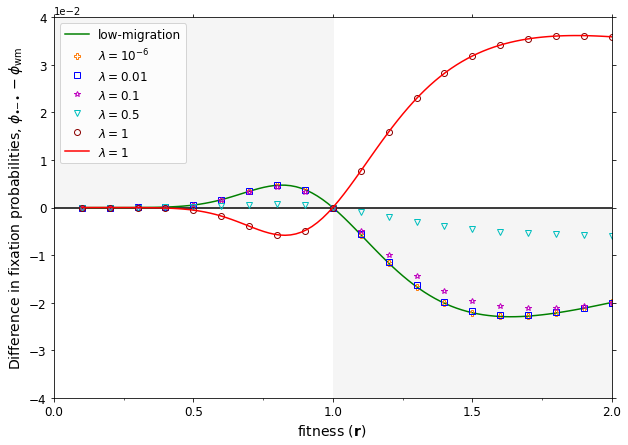

In [37]:

fig, ax = plt.subplots(figsize=(10,7))
ax.xaxis.set_major_locator(MultipleLocator(0.5))
ax.xaxis.set_minor_locator(MultipleLocator(0.25))
ax.ticklabel_format(axis='y',style='sci',scilimits=(0,0))
#ylim=np.array(plt.gca().get_ylim())
ylim=[-0.04,0.04]
plt.xlim(left=0)
plt.xlim(right=2)
plt.ylim(top=ylim[1])
plt.ylim(bottom=ylim[0])
plt.fill_between(np.linspace(0,1,20),y1=0,y2=ylim[1], color='whitesmoke')
plt.fill_between(np.linspace(1.,2,20),y1=ylim[0],y2=0, color='whitesmoke')
ax.axhline(y=0, color='k')
ax.plot(Fitness1, fix_prob_two_patch(Fitness1,local_size_patch_one,local_size_patch_two)- fix_prob_well_mixed(Fitness1,local_size_patch_one+local_size_patch_two ) , color='g',label='low-migration')
ax.plot(Fitness,numerical_fix_prob_10e_6[:,1]- fix_prob_well_mixed(Fitness, local_size_patch_one+local_size_patch_two), 'P',color='tab:orange',markerfacecolor='none',label='$\lambda=10^{-6}$')
ax.plot(Fitness, numerical_fix_prob_10e_2[:,1]- fix_prob_well_mixed(Fitness, local_size_patch_one+local_size_patch_two),'s',color='b',markerfacecolor='none',label='$\lambda=0.01$')
ax.plot(Fitness, numerical_fix_prob_01[:,1]- fix_prob_well_mixed(Fitness, local_size_patch_one+local_size_patch_two),'*',color='m',markerfacecolor='none',label='$\lambda=0.1$')
ax.plot(Fitness, numerical_fix_prob_05[:,1]- fix_prob_well_mixed(Fitness, local_size_patch_one+local_size_patch_two),'v',color='c',markerfacecolor='none',label='$\lambda=0.5$')
ax.plot(Fitness, numerical_fix_prob_1[:,1]- fix_prob_well_mixed(Fitness, local_size_patch_one+local_size_patch_two),'o',color='darkred',markerfacecolor='none',label='$\lambda=1$')
ax.plot(Fitness1, phi(Fitness1,local_size_patch_one,local_size_patch_two)-fix_prob_well_mixed(Fitness1, local_size_patch_one+local_size_patch_two), color='r', label='$\lambda= 1$')
plt.legend(fontsize=12)
ax.tick_params(labelsize=12, direction='out',top=True, right=True)
ax.set_xlabel(r'fitness ($\bf{r}$) ',fontsize=14)
ax.set_ylabel(r"Difference in fixation probabilities, $\phi_{\bullet\!\!-\!\!\bullet}- \phi_{\rm wm} $",fontsize=14)

plt.legend(fontsize=12)
plt.show()